In [2]:
from glob import glob
import os 
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sns.set_style('white', {'axes.grid' : False})

def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

In [3]:
sample_list = ['CRC-P19-T','CRC-P59-T_1','CRC-P59-T_2','CRC-P67-T','LC05-M_DU3','LC05-T_FD3','dcis1','dcis2','slide_DNA','slide_RNA']

In [4]:
plat_color = ['#FF8A7D','#FC8E82','#FA9185','#E47479','#E57579','#E57579'] + ['#F8C170','#FBB479']+ ['#71BE4B'] + ['#00A1DF']
plat = ['stereo-seq']*6 + ['visium'] *2 + ['slide']*2

In [5]:
root_path = "/storage/liuyi/00.SNP_project/code/gigascience_update"

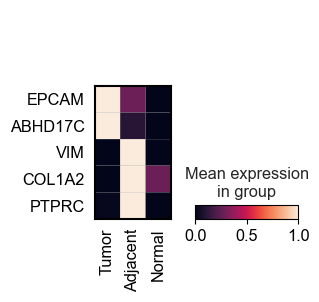

In [6]:
sample = 'dcis1'
rna = sc.read_h5ad(f'{root_path}/rna_adata/{sample}.rna.h5ad')
snv = sc.read_h5ad(f'{root_path}/snv_adata/{sample}.snv.h5ad')
snv.X = snv.layers['norm']
sc.pl.matrixplot(rna,['EPCAM','ABHD17C','VIM','COL1A2','PTPRC'],standard_scale='var',groupby = 'cluster',swap_axes=True,cmap = 'rocket')

In [7]:
# pip install matplotlib_venn

In [8]:
tcga = pd.read_csv(f'{root_path}/otherdata_for_figure/Figure2/brca.csv')
tcga = tcga[tcga['Variant_Type'] == 'SNP']
from matplotlib_venn import venn2
tcga_vc = tcga['Hugo_Symbol'].value_counts()
snv_vc = snv[:,snv.var['gene_name'].map(lambda x: ';' not in x)].var['gene_name'].value_counts()

/tmp/ipykernel_199378/1082769738.py:1: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  tcga = pd.read_csv(f'{root_path}/otherdata_for_figure/Figure2/brca.csv')


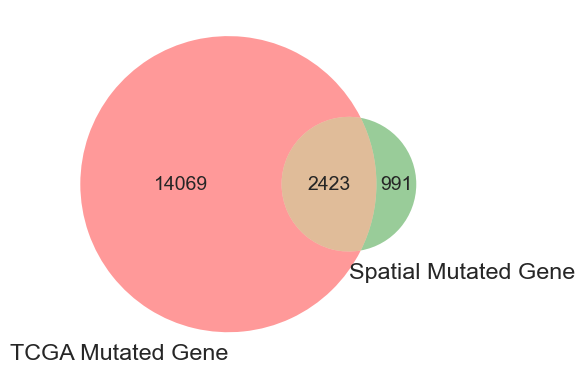

In [9]:
set_tcga = set(tcga_vc[tcga_vc>=1].index)
set_snv = set(snv_vc[snv_vc>=1].index)
fig,ax = plt.subplots(figsize=(5,5))
venn2([set_tcga, set_snv], ('TCGA Mutated Gene', 'Spatial Mutated Gene'),ax= ax)

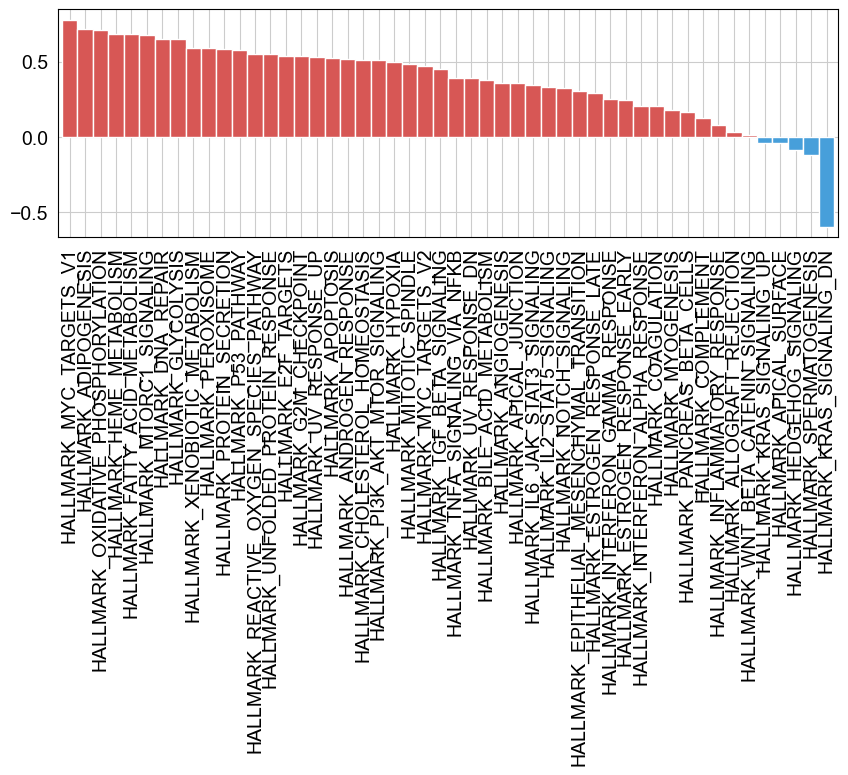

In [10]:
gsva = pd.read_csv(f'{root_path}/otherdata_for_figure/Figure2/{sample}.gsva.csv',index_col=0).T.loc[rna.obs_names]
gsva['snvperumi'] = snv.obs['snvperumi']
correlations = gsva.iloc[:, :-1].apply(lambda col: col.corr(gsva['snvperumi']))
sorted_correlations = correlations.sort_values(ascending=False)
colors = ['#D75755' if val > 0 else '#479FDA' for val in sorted_correlations]
plt.figure(figsize=(10, 3))
sorted_correlations.plot(kind='bar', color=colors,width = 1)
plt.show()

In [11]:
# snv_name = "chr10_8075199:C>A"
# rna_name = "GATA3"
rna_name = "ESR1"
snv_name = "chr6_152103271:T>C"

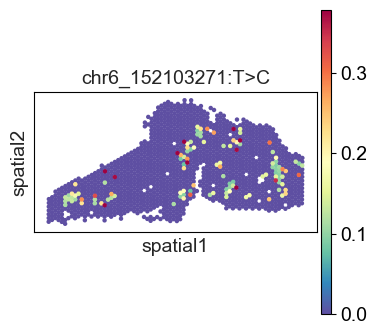

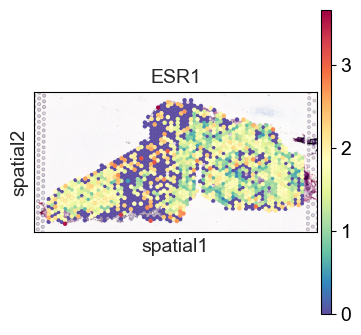

In [12]:
sc.pl.spatial(snv,color= snv_name,spot_size = 70,vmax = 'p99.5',cmap = 'Spectral_r')
sc.pl.spatial(rna,color = rna_name,spot_size = 70,cmap = 'Spectral_r')

In [13]:
snv.obs['cluster'] = rna.obs['cluster']

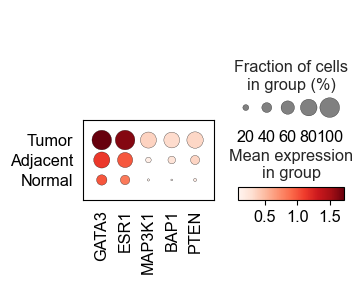

In [14]:
sc.pl.dotplot(rna,var_names = ['GATA3','ESR1','MAP3K1','BAP1','PTEN'],groupby = 'cluster')

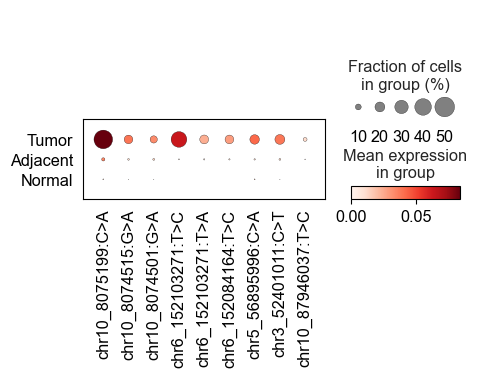

In [15]:
sc.pl.dotplot(snv,var_names = ['chr10_8075199:C>A','chr10_8074515:G>A','chr10_8074501:G>A','chr6_152103271:T>C','chr6_152103271:T>A','chr6_152084164:T>C','chr5_56895996:C>A','chr3_52401011:C>T','chr10_87946037:T>C'],groupby = 'cluster')

In [16]:
snv_meta = snv[:,snv.var['gene_name'].map(lambda x : ';' not in x)].var
genedict = dict(zip(snv_meta['gene_name'],snv_meta['gene_lenth']))
snv_vc = snv_meta['gene_name'].value_counts().reset_index()
snv_vc['gene_lenth'] = snv_vc['index'].map(genedict)
snv_vc['radio'] = snv_vc['gene_name']/snv_vc['gene_lenth'].map(int)
snv_cell = snv_meta[['n_cells','gene_name']].groupby('gene_name').mean()
snv_vc['mean_cell'] = snv_vc['index'].map(dict(zip(snv_cell.index,snv_cell['n_cells'])))

In [17]:
def map_gene_name(gene_name):
    if gene_name.startswith('MT-'):
        return 'MT'
    elif gene_name.startswith('IGK') or gene_name.startswith('IGH') or gene_name.startswith('IGL'):
        return 'BCR'
    else:
        return 'other'

snv_vc['m'] = snv_vc['index'].map(map_gene_name)

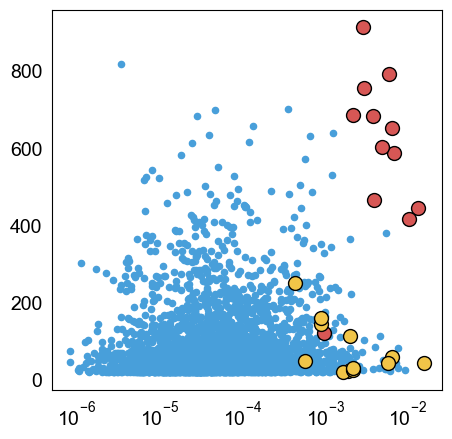

In [18]:
fig,ax = plt.subplots(figsize = (5,5))
color_dict = {'MT':'#D75755','other':'#489FDA','BCR':'#F1C548'}
for itype in ['other', 'MT', 'BCR',]:
    tmp = snv_vc[snv_vc['m'] == itype]
    if itype == 'other':
        ax.scatter(data = tmp,x = 'radio',y = 'mean_cell',s = 20 ,color = color_dict[itype],edgecolor = None,rasterized =True)
    else:
        ax.scatter(data = tmp,x = 'radio',y = 'mean_cell',s = 100 ,color = color_dict[itype],edgecolor = 'black',rasterized =True)
ax.set_xscale('log')
ax.grid(False)
plt.show()

In [19]:
def chi_test(rna_name,snv_name,snv,rna,obs='cluster',obs_dict = {'Tumor':'Tumor','Adjacent':'NoT','Normal':'NoT'} ):
    from scipy.stats import chi2_contingency
    snv.obs[obs] = rna.obs[obs]
    snv.obs['snvtag'] = (np.sum(snv[:,snv_name].X,axis = 1)>0)
    rna.obs['rnatag'] = (np.sum(rna[:,rna_name].X,axis = 1)>0)
    snv.obs[obs] = rna.obs[obs]
    df = snv.obs[[obs,'snvtag']].copy()
    df['rnatag'] = rna.obs['rnatag']
    df[obs] = df[obs].map(obs_dict)
    contingency_table_snv = pd.crosstab(df[obs], df['snvtag'])

    chi2_snv, p_snv, dof_snv, expected_snv = chi2_contingency(contingency_table_snv)

    contingency_table_rna = pd.crosstab(df[obs], df['rnatag'])

    chi2_rna, p_rna, dof_rna, expected_rna = chi2_contingency(contingency_table_rna)
    
    return p_snv,p_rna,contingency_table_snv,contingency_table_rna

In [20]:
snv_name = "chr10_8075199:C>A"
rna_name = "GATA3"
p_snv,p_rna,contingency_table_snv,contingency_table_rna = chi_test(rna_name,snv_name,snv,rna,obs = 'cluster')

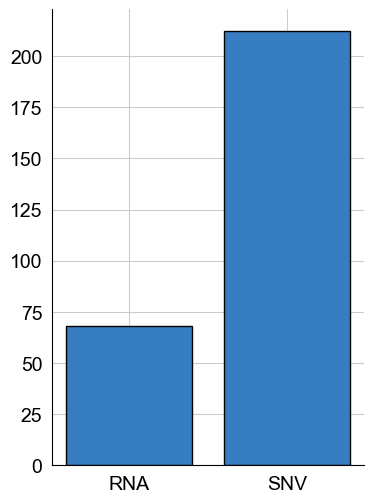

In [21]:
bar_df = pd.DataFrame([p_rna,p_snv])
bar_df['logp'] = -np.log(bar_df[0])
bar_df['type'] = ['RNA','SNV']
fig, ax = plt.subplots(figsize=(4, 6))

ax.bar(data = bar_df ,x = 'type',height = 'logp',edgecolor='black', color='#377DC1')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# CRC-P59-T_1

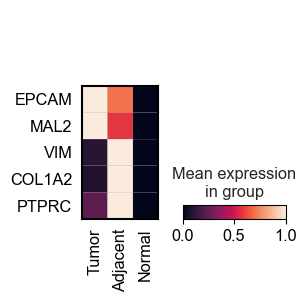

In [22]:
sample = 'CRC-P59-T_1'
rna = sc.read_h5ad(f'{root_path}/rna_adata/{sample}.rna.h5ad')
snv = sc.read_h5ad(f'{root_path}/snv_adata/{sample}.snv.h5ad')
sc.pl.matrixplot(rna,['EPCAM','MAL2','VIM','COL1A2','PTPRC'],standard_scale='var',groupby = 'cluster',swap_axes=True,cmap = 'rocket')

<Axes: >

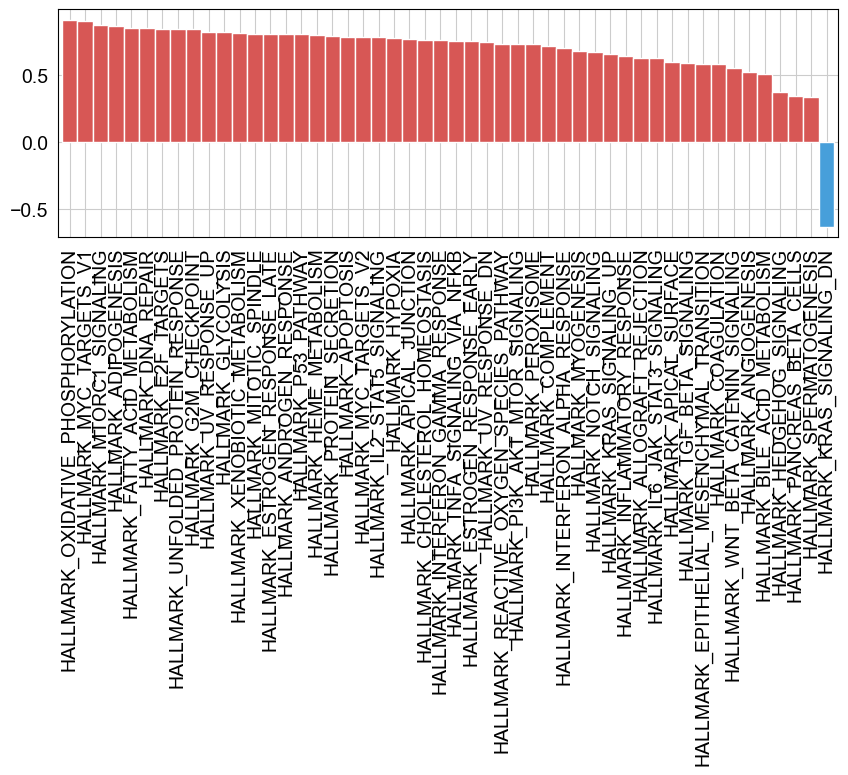

In [23]:
gsva = pd.read_csv(f'{root_path}/otherdata_for_figure/Figure2/{sample}.gsva.csv',index_col=0).T.loc[rna.obs_names]
gsva['snvperumi'] = snv.obs['snvperumi']
correlations = gsva.iloc[:, :-1].apply(lambda col: col.corr(gsva['snvperumi']))
sorted_correlations = correlations.sort_values(ascending=False)
colors = ['#D75755' if val > 0 else '#479FDA' for val in sorted_correlations]
plt.figure(figsize=(10, 3))
sorted_correlations.plot(kind='bar', color=colors,width = 1)

In [24]:
snv_meta = snv[:,snv.var['gene_name'].map(lambda x : ';' not in x)].var
genedict = dict(zip(snv_meta['gene_name'],snv_meta['gene_lenth']))
snv_vc = snv_meta['gene_name'].value_counts().reset_index()
snv_vc['gene_lenth'] = snv_vc['index'].map(genedict)
snv_vc['radio'] = snv_vc['gene_name']/snv_vc['gene_lenth'].map(int)
snv_cell = snv_meta[['n_cells','gene_name']].groupby('gene_name').mean()
snv_vc['mean_cell'] = snv_vc['index'].map(dict(zip(snv_cell.index,snv_cell['n_cells'])))

In [25]:
def map_gene_name(gene_name):
    if gene_name.startswith('MT-'):
        return 'MT'
    elif gene_name.startswith('IGK') or gene_name.startswith('IGH') or gene_name.startswith('IGL'):
        return 'BCR'
    else:
        return 'other'

snv_vc['m'] = snv_vc['index'].map(map_gene_name)

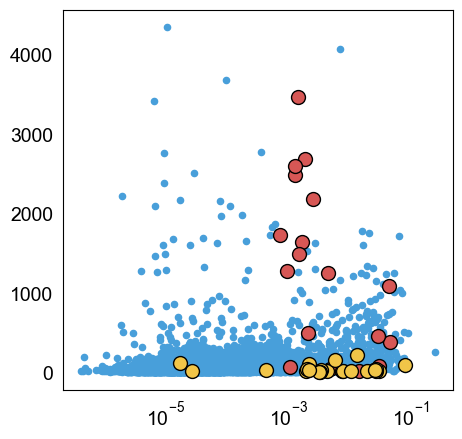

In [26]:
fig,ax = plt.subplots(figsize = (5,5))
color_dict = {'MT':'#D75755','other':'#489FDA','BCR':'#F1C548'}
for itype in ['other', 'MT', 'BCR']:
    tmp = snv_vc[snv_vc['m'] == itype]
    if itype == 'other':
        ax.scatter(data = tmp,x = 'radio',y = 'mean_cell',s = 20 ,color = color_dict[itype],edgecolor = None,rasterized =True)
    else:
        ax.scatter(data = tmp,x = 'radio',y = 'mean_cell',s = 100 ,color = color_dict[itype],edgecolor = 'black',rasterized =True)
ax.set_xscale('log')
ax.grid(False)

In [27]:
tcga = pd.read_csv(f'{root_path}/otherdata_for_figure/Figure2/coad.csv')
tcga = tcga[tcga['Variant_Type'] == 'SNP']
from matplotlib_venn import venn2
tcga_vc = tcga['Hugo_Symbol'].value_counts()
snv_vc = snv[:,snv.var['gene_name'].map(lambda x: ';' not in x)].var['gene_name'].value_counts()

/tmp/ipykernel_199378/1769240499.py:1: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  tcga = pd.read_csv(f'{root_path}/otherdata_for_figure/Figure2/coad.csv')


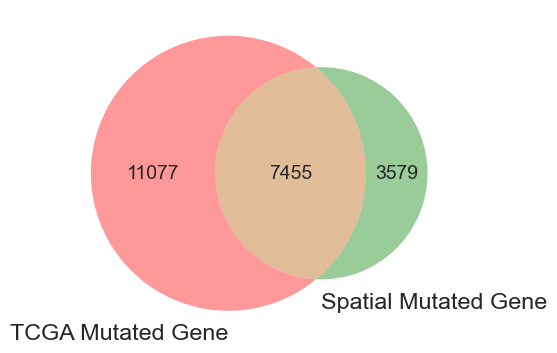

In [28]:
set_tcga = set(tcga_vc[tcga_vc>=1].index)
set_snv = set(snv_vc[snv_vc>=1].index)
fig,ax = plt.subplots(figsize=(5,5))
venn2([set_tcga, set_snv], ('TCGA Mutated Gene', 'Spatial Mutated Gene'),ax= ax)